In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from torch import nn
from torch.utils.data import DataLoader, RandomSampler
from tqdm.notebook import tqdm

from models.energy_models import (EnergyRNN, EnergyRNN2D,
                                  EnergyAttentionRNN, EnergyAttentionRNN2D)
from models.probability_models import (ProbabilityRNN, ProbabilityRNN2D,
                                       ProbabilityAttentionRNN, ProbabilityAttentionRNN2D)
from data_utils.pytorch_datasets import EnergyDataset2D

## Datasets

In [2]:
train_data_path = './data/eval_data.hdf5'
batch_size = 128
n_random_samples = 3200

energy_dataset_2D = EnergyDataset2D(filepath=train_data_path)
random_sampler_2D = RandomSampler(energy_dataset_2D, num_samples=n_random_samples, replacement=True)
energy_loader_2D = DataLoader(
    energy_dataset_2D,
    batch_size=batch_size,
    sampler=random_sampler_2D,
    num_workers=0)

## Energy Models

In [3]:
energy_rnn_base = './model_weights/energy/rnn'
energy_attn_base = './model_weights/energy/rnn_attn'
energy_rnn_paths = {model: os.path.join(energy_rnn_base, model, 'model.ckpt') 
                     for model in os.listdir(energy_rnn_base)}
energy_attn_paths = {model: os.path.join(energy_attn_base, model, 'model.ckpt') 
                      for model in os.listdir(energy_attn_base)}

In [4]:
energy_rnn_models = {}
energy_attn_models = {}
for model, path in energy_rnn_paths.items():
    if '2D' in model:
        energy_rnn_models[model] = EnergyRNN2D.load_from_checkpoint(path).eval()
    else:
        energy_rnn_models[model] = EnergyRNN.load_from_checkpoint(path).eval()
        
for model, path in energy_attn_paths.items():
    if '2D' in model:
        energy_attn_models[model] = EnergyAttentionRNN2D.load_from_checkpoint(path).eval()
    else:
        energy_attn_models[model] = EnergyAttentionRNN.load_from_checkpoint(path).eval()

## Probability Models

In [5]:
prob_rnn_base = './model_weights/probability/rnn'
prob_attn_base = './model_weights/probability/rnn_attn'
prob_rnn_paths = {model: os.path.join(prob_rnn_base, model, 'model.ckpt') 
                     for model in os.listdir(prob_rnn_base)}
prob_attn_paths = {model: os.path.join(prob_attn_base, model, 'model.ckpt') 
                      for model in os.listdir(prob_attn_base)}

In [6]:
prob_rnn_models = {}
prob_attn_models = {}
for model, path in prob_rnn_paths.items():
    if '2D' in model:
        prob_rnn_models[model] = ProbabilityRNN2D.load_from_checkpoint(path).eval()
    else:
        prob_rnn_models[model] = ProbabilityRNN.load_from_checkpoint(path).eval()
        
for model, path in prob_attn_paths.items():
    if '2D' in model:
        prob_attn_models[model] = ProbabilityAttentionRNN2D.load_from_checkpoint(path).eval()
    else:
        prob_attn_models[model] = ProbabilityAttentionRNN.load_from_checkpoint(path).eval()

## Generate Predictions

In [7]:
energy_rnn_preds = defaultdict(list)
energy_attn_preds = defaultdict(list)
prob_rnn_preds = defaultdict(list)
prob_attn_preds = defaultdict(list)
true_energy = []
with torch.no_grad():
    for x_row, x_col, y in tqdm(energy_loader_2D):
        for model_name, model in energy_attn_models.items():
            if '2D' in model_name:
                y_pred, _ = model(x_row, x_col)
            else:
                y_pred, _ = model(x_row)
            energy_attn_preds[model_name].append(y_pred)
                
        for model_name, model in energy_rnn_models.items():
            if '2D' in model_name:
                y_pred = model(x_row, x_col)
            else:
                y_pred = model(x_row)
            energy_rnn_preds[model_name].append(y_pred)
            
        for model_name, model in prob_attn_models.items():
            if '2D' in model_name:
                y_pred = model.predict_energy(x_row, x_col)
            else:
                y_pred = model.predict_energy(x_row)
            prob_attn_preds[model_name].append(y_pred)
                
        for model_name, model in prob_rnn_models.items():
            if '2D' in model_name:
                y_pred = model.predict_energy(x_row, x_col)
            else:
                y_pred = model.predict_energy(x_row)
            prob_rnn_preds[model_name].append(y_pred)
        
        true_energy.append(y)

/home/carlosmiguelpatino/Documents/watch-and-learn/models/energy_models.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H = (1/torch.tensor(self.beta))*(torch.log(prob))


In [8]:
def center_predictions(preds_list):
    preds_tensor = torch.cat(preds_list, axis=0)
    return (preds_tensor - torch.mean(preds_tensor)).squeeze()

In [9]:
centered_energy_rnn_preds = {}
centered_energy_attn_preds = {}
centered_prob_rnn_preds = {}
centered_prob_attn_preds = {}

for model, model_preds in energy_rnn_preds.items():
    centered_energy_rnn_preds[model] = center_predictions(model_preds)
    
for model, model_preds in energy_attn_preds.items():
    centered_energy_attn_preds[model] = center_predictions(model_preds)
    
for model, model_preds in prob_rnn_preds.items():
    centered_prob_rnn_preds[model] = center_predictions(model_preds)
    
for model, model_preds in prob_attn_preds.items():
    centered_prob_attn_preds[model] = center_predictions(model_preds)
    
true_centered = center_predictions(true_energy)

In [30]:
true_centered[torch.randperm(len(true_centered))]

tensor([ 9.9287, -2.0713, 29.9287,  ..., -6.0713, 21.9287, 25.9287])

In [33]:
criterion = nn.MSELoss()
rmse_values = {}
for model, model_preds in centered_energy_rnn_preds.items():
    rmse = torch.sqrt(criterion(true_centered, model_preds))
    rmse_values['energy_rnn/' + model] = rmse.item()
    
for model, model_preds in centered_energy_attn_preds.items():
    rmse = torch.sqrt(criterion(true_centered, model_preds))
    rmse_values['energy_attn/' + model] = rmse.item()
    
for model, model_preds in centered_prob_rnn_preds.items():
    rmse = torch.sqrt(criterion(true_centered, model_preds))
    rmse_values['prob_rnn/' + model] = rmse.item()
    
for model, model_preds in centered_prob_attn_preds.items():
    rmse = torch.sqrt(criterion(true_centered, model_preds))
    rmse_values['prob_attn/' + model] = rmse.item()

In [34]:
{k: v for k, v in sorted(rmse_values.items(), key=lambda item: item[1])}

{'energy_attn/2D_GRU_1L_1H_Bi': 7.881624698638916,
 'energy_attn/2D_GRU_1L_1H': 10.246170997619629,
 'energy_attn/GRU_1L_1H_Bi': 11.426187515258789,
 'energy_rnn/2D_GRU_1L_Bi': 12.691633224487305,
 'energy_attn/GRU_1L_1H': 12.864775657653809,
 'energy_rnn/GRU_1L_Bi': 13.63366985321045,
 'energy_rnn/2D_GRU_1L': 14.186531066894531,
 'energy_rnn/LSTM_1L_Bi': 14.261340141296387,
 'energy_rnn/LSTM_1L': 15.474346160888672,
 'energy_rnn/GRU_1L': 15.73843002319336,
 'prob_rnn/LSTM_1L': 19.771570205688477,
 'prob_rnn/GRU_1L': 19.828289031982422,
 'prob_rnn/2D_GRU_1L': 20.02991485595703,
 'prob_attn/2D_GRU_1L_1H': 22.227018356323242,
 'prob_rnn/2D_GRU_1L_Bi': 22.359949111938477,
 'prob_rnn/GRU_1L_Bi': 23.826507568359375,
 'prob_rnn/LSTM_1L_Bi': 23.879026412963867,
 'prob_attn/2D_GRU_1L_1H_Bi': 24.414470672607422,
 'prob_attn/GRU_1L_1H_Bi': 25.549205780029297,
 'prob_attn/GRU_1L_1H': 27.361154556274414}

In [12]:
def plot_difference(true_centered, model_centered_preds, ax, label, delta=False):

    diffs = model_centered_preds - true_centered
    buckets = defaultdict(list)
    for true, pred in zip(true_centered, diffs):
        buckets[true].append(pred)

    n_buckets = len(buckets)
    y_high = np.zeros(n_buckets)
    y_center = np.zeros(n_buckets)
    y_low = np.zeros(n_buckets)
    x_vals = np.zeros(n_buckets)
    for i, key in enumerate(sorted(buckets.keys())):
        x_vals[i] = key
        diffs_arr = np.array(buckets[key])
        mean = np.mean(diffs_arr)
        std = np.std(diffs_arr)
        y_low[i] = mean - 2*std
        y_center[i] = mean
        y_high[i] = mean + 2*std
        
    if delta:
        ax.fill_between(x_vals, y_high, y_low, alpha=0.2)
    ax.plot(x_vals, y_center, label=label)

Text(0.5, 0, '$E(\\sigma_{i}) - \\overline{E(\\sigma)}$')

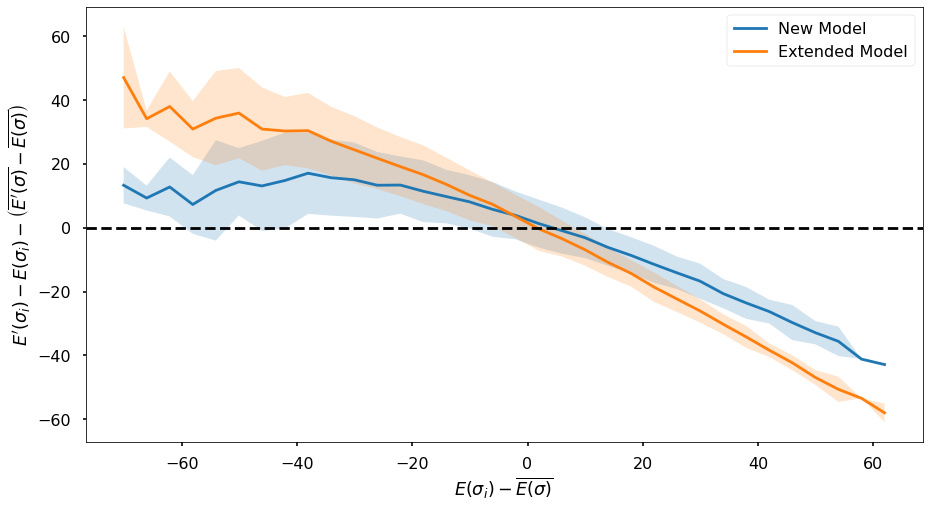

In [38]:
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(figsize=(15, 8))
delta = True

best_model = '2D_GRU_1L_Bi'
best_preds = centered_energy_rnn_preds[best_model]
ref_model = 'GRU_1L'
ref_preds = centered_prob_rnn_preds[ref_model]

plot_difference(true_centered.numpy(), best_preds.numpy(), ax, 'New Model', delta)
plot_difference(true_centered.numpy(), ref_preds.numpy(), ax, 'Extended Model', delta)
ax.legend()
ax.axhline(0, linestyle='--', c='black')
ax.set_ylabel(r"${E}'(\sigma_{i}) - E(\sigma_{i})- \left(\overline{{E}'(\sigma)} - \overline{E(\sigma)}\right)$")
ax.set_xlabel(r"$E(\sigma_{i}) - \overline{E(\sigma)}$")